# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

In [2]:
random_state = 200

# Load Dataset D (Perempuan Genap)

In [3]:
dataset = pd.read_csv('./Dataset/data_1D.csv')
dataset.head()

Unnamed: 0  age       job   marital          education default housing  \
0           0   83   retired  divorced           basic.4y      no      no   
1           1   32  services   married        high.school      no      no   
2           2   31    admin.    single  university.degree      no     yes   
3           3   33    admin.    single  university.degree      no     yes   
4           4   39  services   married        high.school      no     yes   

  loan    contact month day_of_week  duration  campaign  pdays  previous  \
0   no   cellular   nov         tue     242.0         1      3         3   
1   no  telephone   may         tue     190.0         3    999         0   
2   no  telephone   may         wed     325.0         2    999         0   
3   no  telephone   aug         thu     158.0         1    999         0   
4   no  telephone   jul         mon     158.0         1    999         0   

      poutcome    y  
0      success  yes  
1  nonexistent   no  
2  nonexistent   no  
3  nonexistent   no  
4  nonexistent   no

# Filter Dataset

We will drop useless id column like Unnamed: 0. We will also drop month and day_of_week because it's already represented by duration.

In [4]:
dataset = dataset.drop(columns=['Unnamed: 0', 'month', 'day_of_week'], axis=1)

# EDA

## Data Head

In [5]:
dataset.head()

age       job   marital          education default housing loan    contact  \
0   83   retired  divorced           basic.4y      no      no   no   cellular   
1   32  services   married        high.school      no      no   no  telephone   
2   31    admin.    single  university.degree      no     yes   no  telephone   
3   33    admin.    single  university.degree      no     yes   no  telephone   
4   39  services   married        high.school      no     yes   no  telephone   

   duration  campaign  pdays  previous     poutcome    y  
0     242.0         1      3         3      success  yes  
1     190.0         3    999         0  nonexistent   no  
2     325.0         2    999         0  nonexistent   no  
3     158.0         1    999         0  nonexistent   no  
4     158.0         1    999         0  nonexistent   no

## Data Info

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        8238 non-null   int64  
 1   job        8230 non-null   object 
 2   marital    8238 non-null   object 
 3   education  8238 non-null   object 
 4   default    8238 non-null   object 
 5   housing    8238 non-null   object 
 6   loan       8238 non-null   object 
 7   contact    8238 non-null   object 
 8   duration   8226 non-null   float64
 9   campaign   8238 non-null   int64  
 10  pdays      8238 non-null   int64  
 11  previous   8238 non-null   int64  
 12  poutcome   8238 non-null   object 
 13  y          8238 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 901.2+ KB


## Data Distribution

In [7]:
numerical_data = dataset.select_dtypes(include=[np.number])
categorical_data = dataset.select_dtypes(exclude=[np.number])

### Numerical Data

<Figure size 1000x600 with 0 Axes>

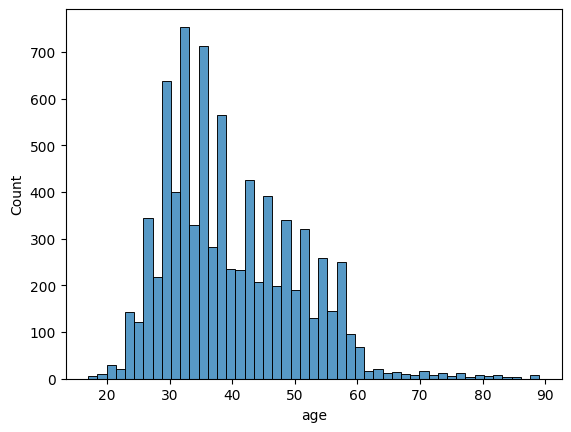

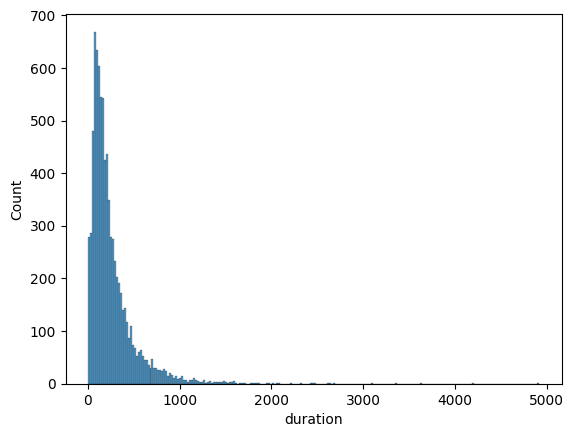

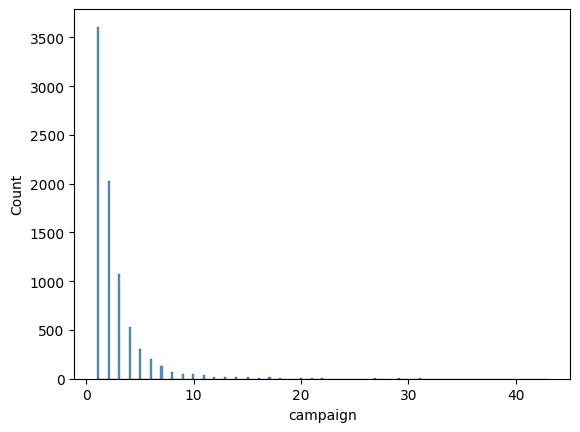

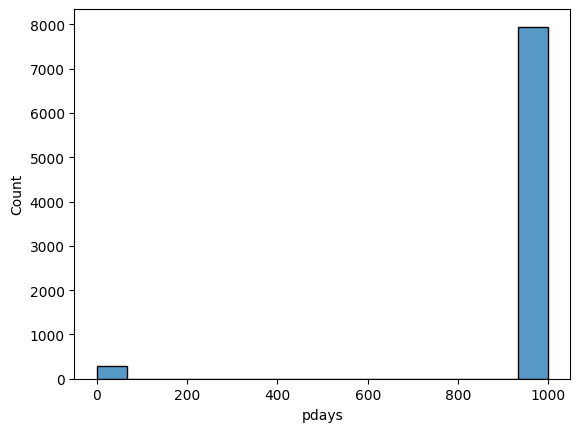

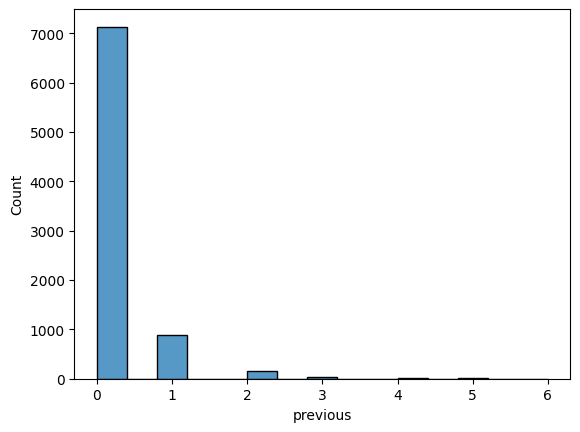

In [8]:
fig = plt.figure(figsize=(10, 6))
for column in numerical_data.columns:
    plt.figure()
    sns.histplot(numerical_data[column])

Apart from age all of the data seems to be skewed to the right. We will need to normalize the data.

### Categorical Data

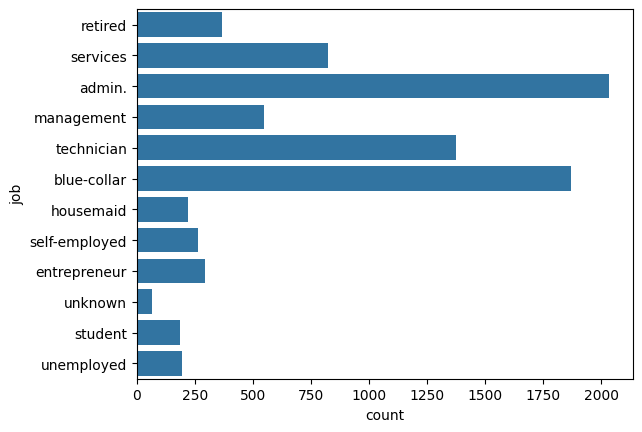

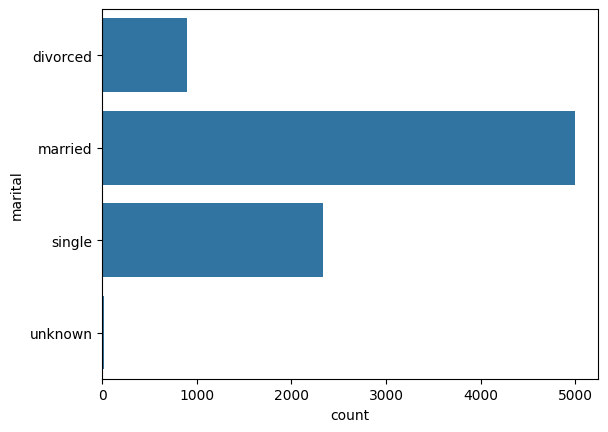

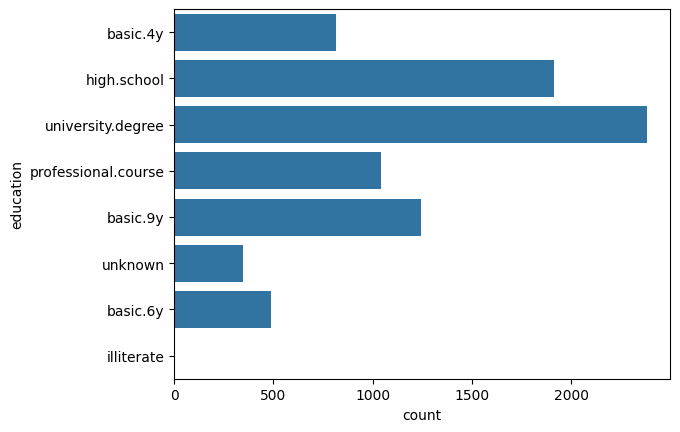

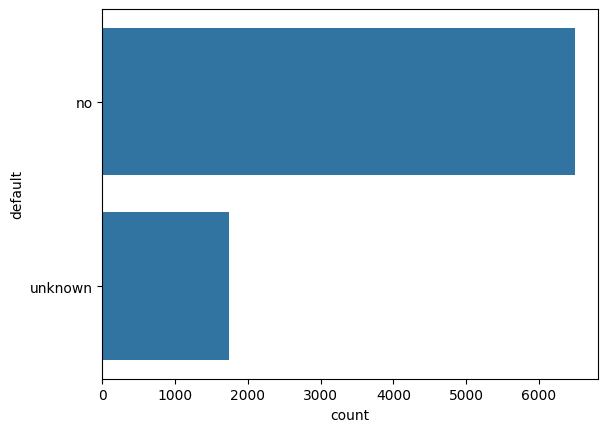

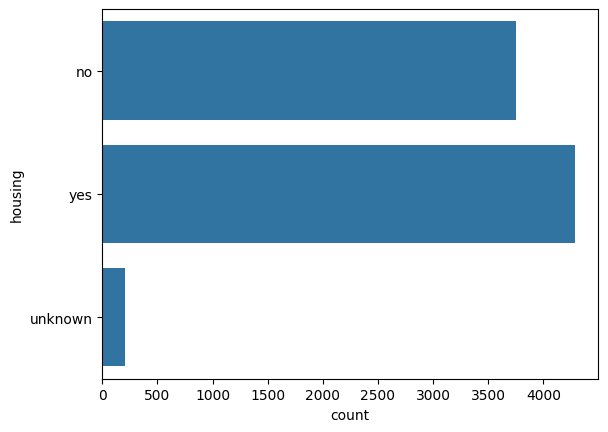

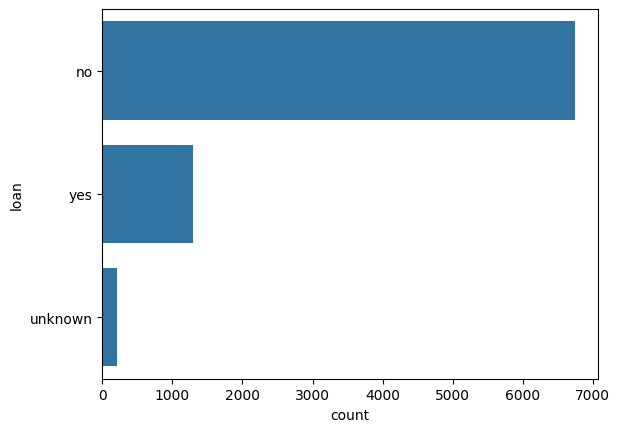

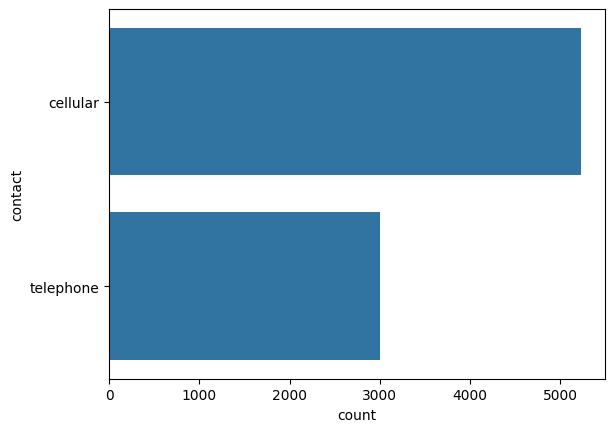

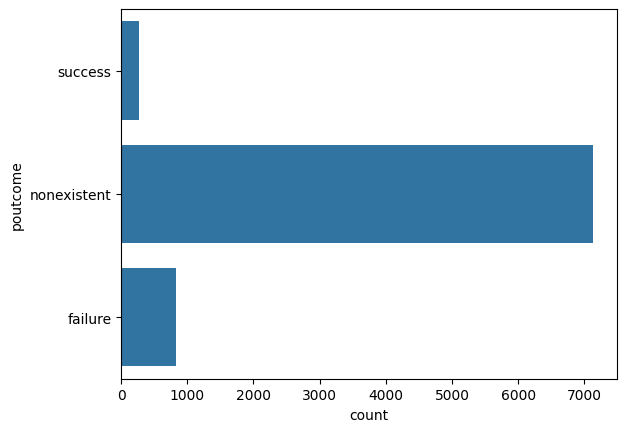

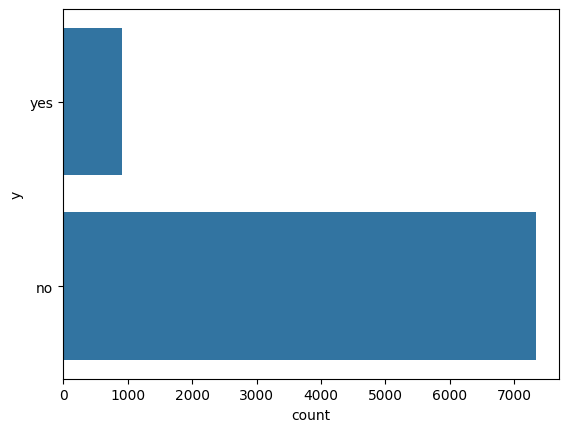

In [9]:
for column in categorical_data.columns:
    plt.figure()
    sns.countplot(categorical_data[column])

There seems to be some "unknown" values in the dataset thats not represented by NaN. We will assume that "unknown" is not a missing value and is a feature of the data. For the distribution of the data we can see that the data is imbalanced. We will need to balance the data using oversampling.

## Data Missing Values

In [10]:
dataset.isnull().sum()

age           0
job           8
marital       0
education     0
default       0
housing       0
loan          0
contact       0
duration     12
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64

There's some missing value in the dataset. We will need to fill the missing value.

## Data Correlation

<Axes: >

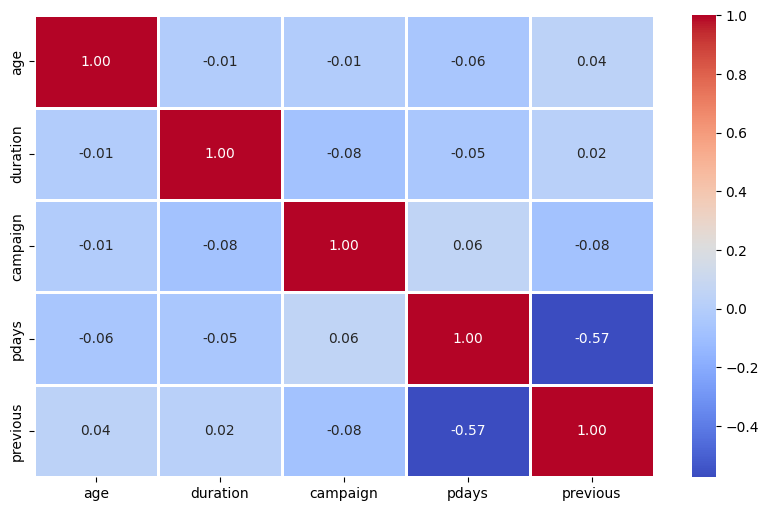

In [11]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)

pdays and previous seems to be correlated. We will need to drop one of the column to avoid multicollinearity.

# Data Preprocessing

## Drop Columns

In [12]:
dataset = dataset.drop(columns=['pdays'], axis=1)

## Train Test Split

In [13]:
X, y = dataset.drop(columns=['y'], axis=1), dataset['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [14]:
X_train.shape, X_test.shape

((6590, 12), (1648, 12))

## Fill Missing Values

In [15]:
for column in X_train.columns:
    if X_train[column].isnull().sum() > 0:
        if X_train[column].dtype == 'object':
            X_train[column] = X_train[column].fillna(X_train[column].mode()[0])
        else:
            X_train[column] = X_train[column].fillna(X_train[column].mean())

In [16]:
for column in X_test.columns:
    if X_test[column].isnull().sum() > 0:
        if X_test[column].dtype == 'object':
            X_test[column] = X_test[column].fillna(X_test[column].mode()[0])
        else:
            X_test[column] = X_test[column].fillna(X_test[column].mean())

## Scale Data [0,1]

In [17]:
scaler = MinMaxScaler()

numeric_X_train = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
numeric_X_test = scaler.transform(X_test.select_dtypes(include=[np.number]))

## Encode Categorical Data

In [18]:
encoder = OrdinalEncoder()

categorical_X_train = encoder.fit_transform(X_train.select_dtypes(exclude=[np.number]))
categorical_X_test = encoder.transform(X_test.select_dtypes(exclude=[np.number]))

## Concat Data

In [19]:
preProcessed_X_train = np.concatenate([numeric_X_train, categorical_X_train], axis=1)
preProcessed_X_test = np.concatenate([numeric_X_test, categorical_X_test], axis=1)

In [20]:
preProcessed_X_train = pd.DataFrame(preProcessed_X_train, columns=X_train.columns)
preProcessed_X_test = pd.DataFrame(preProcessed_X_test, columns=X_test.columns)

# Oversampling

In [21]:
oversampler = RandomOverSampler()

preProcessed_X_train, y_train = oversampler.fit_resample(preProcessed_X_train, y_train)

# Model Selection

## Logistic Regression

In [22]:
logis_reg = LogisticRegression(random_state=random_state, max_iter=1000)

logis_reg.fit(preProcessed_X_train, y_train)

LogisticRegression(max_iter=1000, random_state=200)

In [23]:
predictions = logis_reg.predict(preProcessed_X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          no       0.96      0.84      0.90      1472
         yes       0.35      0.70      0.47       176

    accuracy                           0.83      1648
   macro avg       0.66      0.77      0.68      1648
weighted avg       0.89      0.83      0.85      1648



## Decision Tree

In [24]:
dt_tree = DecisionTreeClassifier(random_state=random_state)

dt_tree.fit(preProcessed_X_train, y_train)

DecisionTreeClassifier(random_state=200)

In [25]:
predictions = dt_tree.predict(preProcessed_X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          no       0.92      0.93      0.93      1472
         yes       0.38      0.36      0.37       176

    accuracy                           0.87      1648
   macro avg       0.65      0.65      0.65      1648
weighted avg       0.87      0.87      0.87      1648



## SVC

In [26]:
svc = SVC(random_state=random_state)

svc.fit(preProcessed_X_train, y_train)

SVC(random_state=200)

In [27]:
predictions = svc.predict(preProcessed_X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          no       0.94      0.70      0.80      1472
         yes       0.21      0.65      0.31       176

    accuracy                           0.69      1648
   macro avg       0.58      0.68      0.56      1648
weighted avg       0.87      0.69      0.75      1648



# Conclusion

From all of the model above, we can conclude that Decision Tree is the best model for this dataset because it got the highest precision of positive value of 0.38 or 38% precision. We didn't use ensemble model because the it's a case that involves money, so it's better to have a model that is easier to interpret.

# Save Model, scaler, and encoder

In [29]:
model_package = {
    "model" : dt_tree,
    "scaler" : scaler,
    "encoder" : encoder,
}

with open('model_package.pkl', 'wb') as file:
    pickle.dump(model_package, file)
    
print("Model has been saved successfully!")

Model has been saved successfully!


Video Link
https://drive.google.com/file/d/1Yo_QT0S2i0R6kBCvXPufltbzxXAlI4QS/view?usp=sharing 